In [1]:
!pip install wordcloud

In [28]:
# Imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, when, lower, length
from pyspark.sql.types import StringType, DoubleType, ArrayType, StructType, StructField
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.fpm import FPGrowth
from pyspark.sql import functions as F
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import re
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
from pyspark.sql.functions import collect_list, explode
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.storagelevel import StorageLevel
import matplotlib.pyplot as plt


nltk.download('vader_lexicon')

# Spark Session with optimized settings
spark = SparkSession.builder \
    .appName("ClimateSentimentAnalysis") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "2g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.default.parallelism", "8") \
    .getOrCreate()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [29]:
# Load dataset
df = spark.read.csv("/content/twitter_sentiment_data.csv", header=True, inferSchema=True)
df = df.drop('tweetid').dropna(subset=['message'])
df.persist(StorageLevel.MEMORY_AND_DISK)  # Persist to memory and disk

DataFrame[sentiment: string, message: string]

In [30]:
def clean_text(text):
    if text is None:
        return ""
    text = re.sub(r"^rt\s+", "", text, flags=re.IGNORECASE)  # Remove 'rt ' from start
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"@\w+|\#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"[^\x00-\x7F]+", "", text)
    text = re.sub(r"\s+", " ", text).strip().lower()
    return text

# Register UDF
clean_text_udf = udf(clean_text, StringType())

# Apply Cleaning
df = df.withColumn("message", clean_text_udf(col("message")))

# Drop duplicates based on cleaned text
df = df.dropDuplicates(["message"])

# Cache cleaned and deduplicated DataFrame
df.cache()


DataFrame[sentiment: string, message: string]

In [31]:
# Map Sentiment Labels
def map_sentiment(s):
    s = str(s).lower()
    if s in ["1", "1.0"]:
        return "positive"
    elif s in ["-1", "-1.0"]:
        return "negative"
    elif s in ["0", "0.0", "2", "2.0"]:
        return "neutral"
    return "unknown"

map_sentiment_udf = udf(map_sentiment, StringType())
df = df.withColumn("sentiment_label", map_sentiment_udf(col("sentiment")))
df = df.filter(col("sentiment_label") != "unknown")

# Multiclass label (0.0: negative, 1.0: neutral, 2.0: positive)
df = df.withColumn("label", when(col("sentiment_label") == "positive", 2.0)
                          .when(col("sentiment_label") == "neutral", 1.0)
                          .otherwise(0.0))

# Binary label for GBTClassifier (0.0: negative, 1.0: neutral/positive)
df = df.withColumn("binary_label", when(col("sentiment_label") == "negative", 0.0).otherwise(1.0))
df.cache()

DataFrame[sentiment: string, message: string, sentiment_label: string, label: double, binary_label: double]

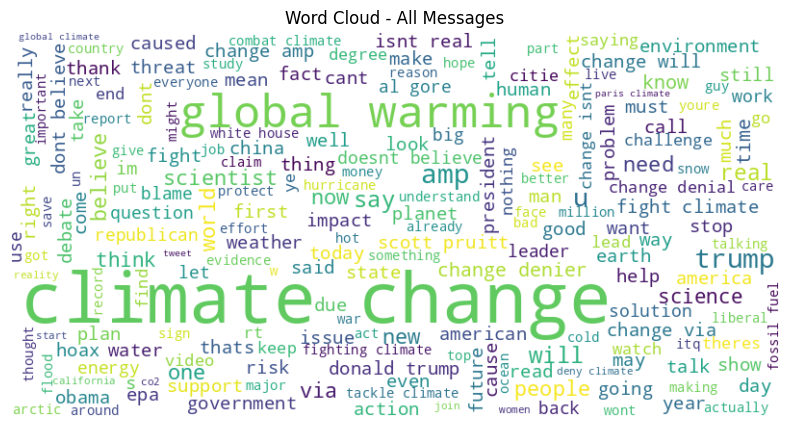

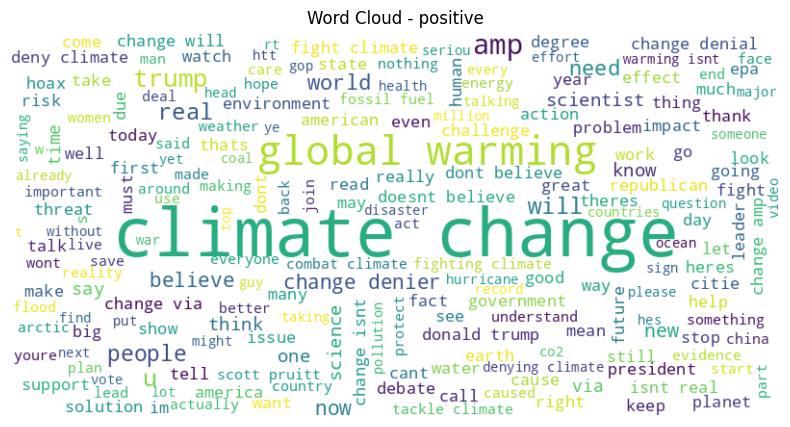

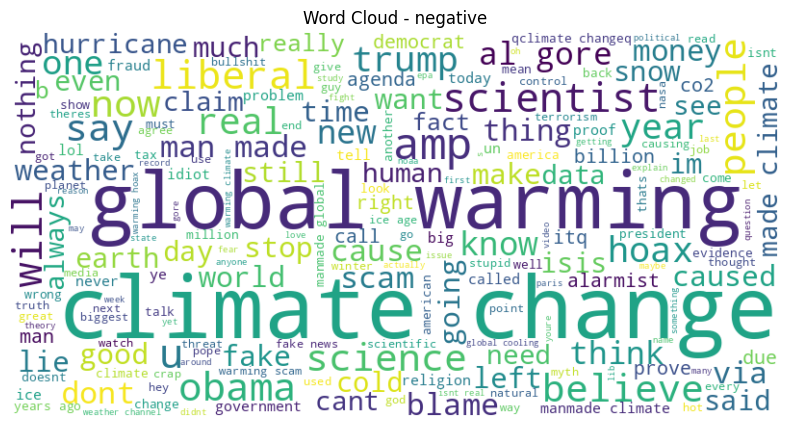

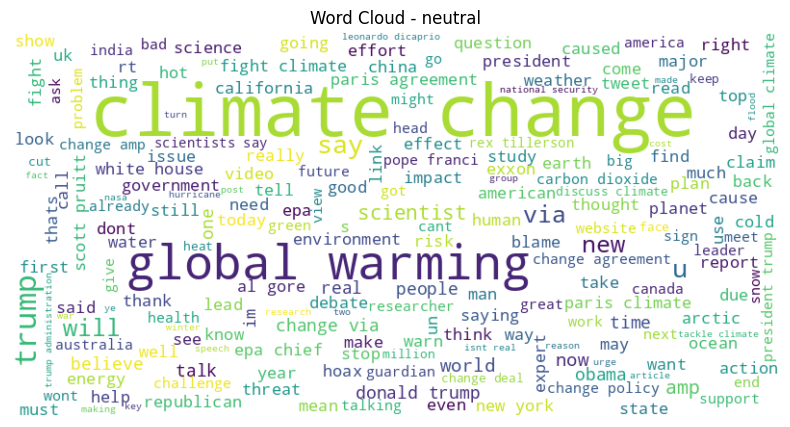

In [32]:
from wordcloud import WordCloud
all_text = ' '.join(df.select('message').rdd.flatMap(lambda x: x).collect())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - All Messages')
plt.show()
for label in ['positive', 'negative', 'neutral']:
    label_text = ' '.join(df.filter(df.sentiment_label == label).select('message').rdd.flatMap(lambda x: x).collect())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(label_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - {label}')
    plt.show()

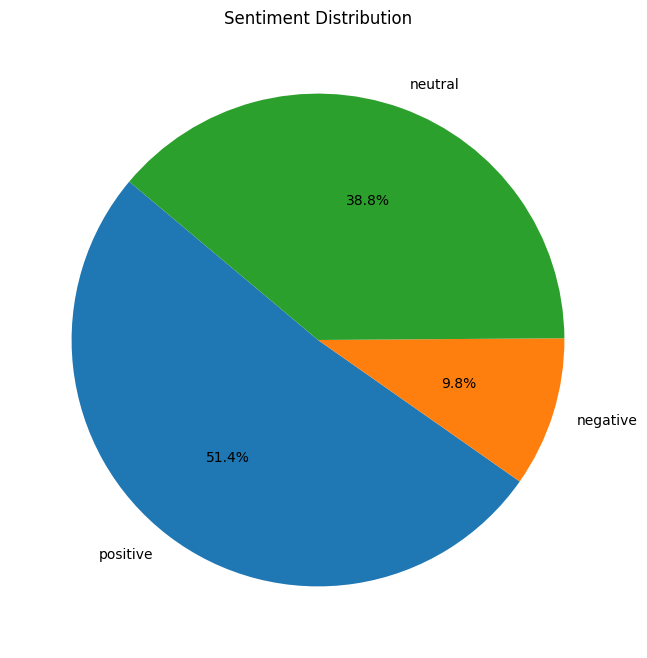

In [33]:
sentiment_counts = df.groupBy('sentiment_label').count().toPandas()
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts['count'], labels=sentiment_counts['sentiment_label'], autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution')
plt.show()

In [34]:
# Feature Engineering
sid = SentimentIntensityAnalyzer()
def get_vader_score(text):
    return float(sid.polarity_scores(text)['compound'])

vader_udf = udf(get_vader_score, DoubleType())
df = df.withColumn("vader_compound", vader_udf(col("message")))

df = df.withColumn("text_length", length(col("message")))

climate_keywords = ['climate', 'warming', 'environment', 'carbon', 'emissions']
def has_keywords(text):
    return 1.0 if any(keyword in text for keyword in climate_keywords) else 0.0

has_keywords_udf = udf(has_keywords, DoubleType())
df = df.withColumn("has_climate_keywords", has_keywords_udf(col("message")))
df.persist(StorageLevel.MEMORY_AND_DISK)  # Persist after feature engineering

DataFrame[sentiment: string, message: string, sentiment_label: string, label: double, binary_label: double, vader_compound: double, text_length: int, has_climate_keywords: double]

In [35]:
# VADER Sentiment Prediction
# Map VADER compound scores to sentiment labels
def vader_sentiment(score):
    if score >= 0.05:
        return 2.0  # positive
    elif score <= -0.05:
        return 0.0  # negative
    else:
        return 1.0  # neutral

vader_sentiment_udf = udf(vader_sentiment, DoubleType())

# Add VADER predicted label to DataFrame
df_vader = df.withColumn("vader_predicted_label", vader_sentiment_udf(col("vader_compound")))

# Evaluate VADER's performance
vader_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="vader_predicted_label", metricName="accuracy")
vader_accuracy = vader_evaluator.evaluate(df_vader)

print(f"VADER Sentiment Analysis Accuracy: {vader_accuracy}")

# Generate confusion matrix for VADER
vader_prediction_and_labels = df_vader.select("vader_predicted_label", "label")
metrics = MulticlassMetrics(vader_prediction_and_labels.rdd.map(tuple))

confusion_matrix_vader = metrics.confusionMatrix().toArray()
print("VADER Confusion Matrix:")
print(confusion_matrix_vader)

# Function to print classification report like output
def print_classification_report(confusion_matrix, labels):
    report = {}
    for i, label in enumerate(labels):
        true_positives = confusion_matrix[i][i]
        false_positives = confusion_matrix[:, i].sum() - true_positives
        false_negatives = confusion_matrix[i, :].sum() - true_positives
        true_negatives = confusion_matrix.sum() - true_positives - false_positives - false_negatives

        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        support = confusion_matrix[i, :].sum()

        report[label] = {
            'precision': precision,
            'recall': recall,
            'f1-score': f1_score,
            'support': support
        }
    return report

labels = ["negative", "neutral", "positive"] # Corresponding to 0.0, 1.0, 2.0
vader_report = print_classification_report(confusion_matrix_vader, labels)

print("\nVADER Classification Report:")
for label, metrics in vader_report.items():
    print(f"{label}:")
    print(f"  Precision: {metrics['precision']:.2f}")
    print(f"  Recall: {metrics['recall']:.2f}")
    print(f"  F1-Score: {metrics['f1-score']:.2f}")
    print(f"  Support: {metrics['support']}")

overall_precision_vader = confusion_matrix_vader.diagonal().sum() / confusion_matrix_vader.sum()
print(f"\nOverall Precision (VADER): {overall_precision_vader:.2f}")

overall_recall_vader = confusion_matrix_vader.diagonal().sum() / confusion_matrix_vader.sum()
print(f"Overall Recall (VADER): {overall_recall_vader:.2f}")

# F1 score calculation for overall
overall_f1_vader = 2 * (overall_precision_vader * overall_recall_vader) / (overall_precision_vader + overall_recall_vader) if (overall_precision_vader + overall_recall_vader) > 0 else 0
print(f"Overall F1-Score (VADER): {overall_f1_vader:.2f}")

# Filter misclassified tweets
misclassified_df = df_vader.filter(col("label") != col("vader_predicted_label"))

# Show a few misclassified examples
misclassified_df.select("message", "label", "vader_predicted_label", "vader_compound").show(10, truncate=False)


VADER Sentiment Analysis Accuracy: 0.3620379083210109


/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


VADER Confusion Matrix:
[[1713.  581. 1369.]
 [4513. 4565. 5345.]
 [7597. 4324. 7188.]]

VADER Classification Report:
negative:
  Precision: 0.12
  Recall: 0.47
  F1-Score: 0.20
  Support: 3663.0
neutral:
  Precision: 0.48
  Recall: 0.32
  F1-Score: 0.38
  Support: 14423.0
positive:
  Precision: 0.52
  Recall: 0.38
  F1-Score: 0.44
  Support: 19109.0

Overall Precision (VADER): 0.36
Overall Recall (VADER): 0.36
Overall F1-Score (VADER): 0.36
+-------------------------------------------------------------------------------------------------------------------------------------+-----+---------------------+--------------+
|message                                                                                                                              |label|vader_predicted_label|vader_compound|
+-------------------------------------------------------------------------------------------------------------------------------------+-----+---------------------+--------------+
|0those arguing a

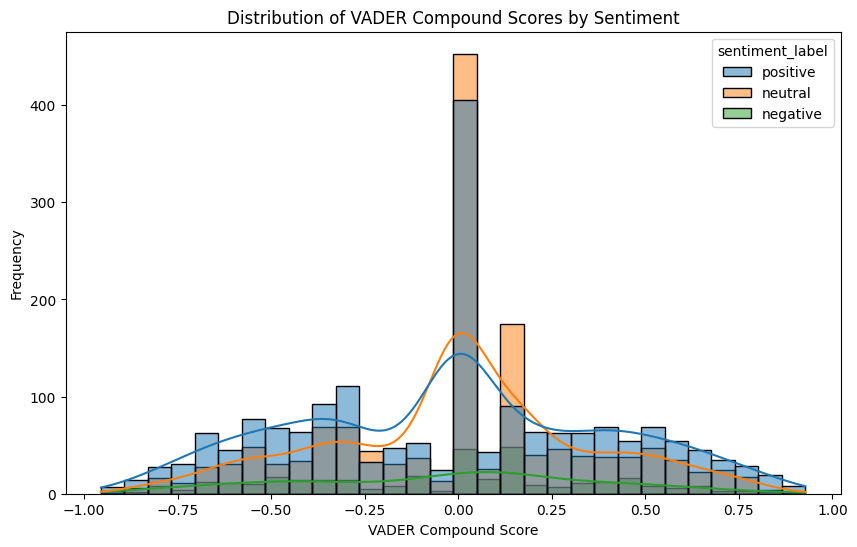

In [36]:
import seaborn as sns
vader_sample = df.select('vader_compound', 'sentiment_label').sample(False, 0.1, seed=42).toPandas()
plt.figure(figsize=(10, 6))
sns.histplot(data=vader_sample, x='vader_compound', hue='sentiment_label', kde=True, bins=30)
plt.title('Distribution of VADER Compound Scores by Sentiment')
plt.xlabel('VADER Compound Score')
plt.ylabel('Frequency')
plt.show()

<ipython-input-37-543bc0ffc790>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=vader_sample, x='sentiment_label', y='vader_compound', palette='Set2')


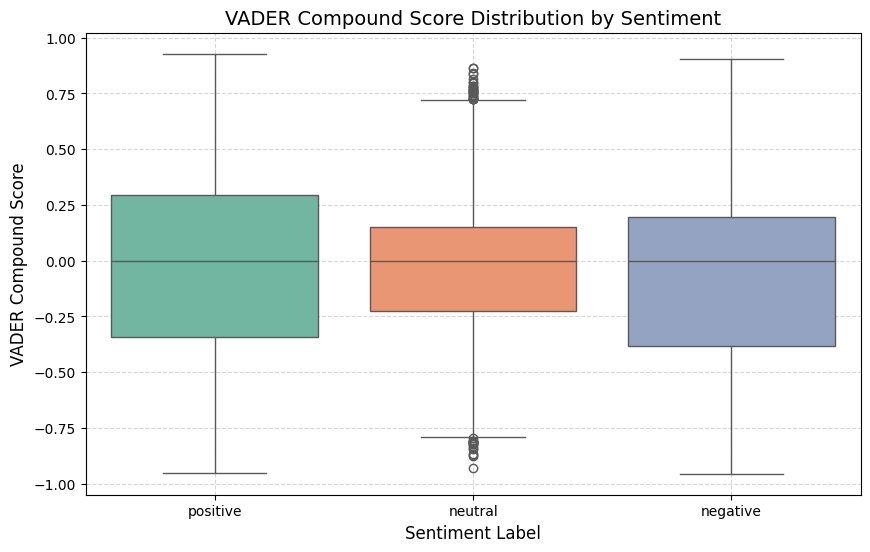

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample and convert to Pandas
vader_sample = df.select('vader_compound', 'sentiment_label').sample(False, 0.1, seed=42).toPandas()

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=vader_sample, x='sentiment_label', y='vader_compound', palette='Set2')

# Add title and labels
plt.title('VADER Compound Score Distribution by Sentiment', fontsize=14)
plt.xlabel('Sentiment Label', fontsize=12)
plt.ylabel('VADER Compound Score', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [39]:
# Feature Extraction Pipeline
tokenizer = Tokenizer(inputCol="message", outputCol="words")
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=500)  # Further reduced features
idf = IDF(inputCol="rawFeatures", outputCol="tfidf_features")

text_pipeline = Pipeline(stages=[tokenizer, hashingTF, idf])
text_model = text_pipeline.fit(df)
df = text_model.transform(df)
df.cache()  # Cache transformed DataFrame

DataFrame[sentiment: string, message: string, sentiment_label: string, label: double, binary_label: double, vader_compound: double, text_length: int, has_climate_keywords: double, words: array<string>, rawFeatures: vector, tfidf_features: vector]

In [40]:
# Import VectorAssembler
from pyspark.ml.feature import VectorAssembler

# Apply SMOTE and Convert Array to VectorUDT
from pyspark.ml.linalg import Vectors, VectorUDT
pandas_df = df.select("tfidf_features", "vader_compound", "text_length", "has_climate_keywords", "label", "binary_label").toPandas()
X = np.hstack([pandas_df["tfidf_features"].apply(lambda x: x.toArray()).tolist(),
               pandas_df[["vader_compound", "text_length", "has_climate_keywords"]].values])
y_multi = pandas_df["label"].values
y_binary = pandas_df["binary_label"].values

# SMOTE for multiclass labels
smote_multi = SMOTE(random_state=42, sampling_strategy='auto', k_neighbors=3)
X_resampled_multi, y_resampled_multi = smote_multi.fit_resample(X, y_multi)

# SMOTE for binary labels
smote_binary = SMOTE(random_state=42, sampling_strategy='auto', k_neighbors=3)
X_resampled_binary, y_resampled_binary = smote_binary.fit_resample(X, y_binary)

# Define UDF to convert array to VectorUDT
array_to_vector_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())

# Schema for both DataFrames
schema = StructType([
    StructField("label", DoubleType(), False),
    StructField("binary_label", DoubleType(), False),
    StructField("tfidf_features", ArrayType(DoubleType()), False),
    StructField("vader_compound", DoubleType(), False),
    StructField("text_length", DoubleType(), False),
    StructField("has_climate_keywords", DoubleType(), False)
])

# Multiclass resampled data
resampled_data_multi = [
    (float(y_resampled_multi[i]), float(y_resampled_multi[i]),  # Use multiclass label for both
     [float(x) for x in X_resampled_multi[i][:500]],
     float(X_resampled_multi[i][500]),
     float(X_resampled_multi[i][501]),
     float(X_resampled_multi[i][502]))
    for i in range(len(X_resampled_multi))
]

# Binary resampled data
resampled_data_binary = [
    (float(y_resampled_binary[i]), float(y_resampled_binary[i]),
     [float(x) for x in X_resampled_binary[i][:500]],
     float(X_resampled_binary[i][500]),
     float(X_resampled_binary[i][501]),
     float(X_resampled_binary[i][502]))
    for i in range(len(X_resampled_binary))
]

# Create DataFrames
balanced_df_multi = spark.createDataFrame(resampled_data_multi, schema)
balanced_df_binary = spark.createDataFrame(resampled_data_binary, schema)

# Convert tfidf_features to VectorUDT
balanced_df_multi = balanced_df_multi.withColumn("tfidf_vector", array_to_vector_udf(col("tfidf_features")))
balanced_df_binary = balanced_df_binary.withColumn("tfidf_vector", array_to_vector_udf(col("tfidf_features")))

# Assemble features
assembler = VectorAssembler(
    inputCols=["tfidf_vector", "vader_compound", "text_length", "has_climate_keywords"],
    outputCol="features"
)
balanced_df_multi = assembler.transform(balanced_df_multi).select("label", "features")
balanced_df_binary = assembler.transform(balanced_df_binary).select("binary_label", "features")

# Persist DataFrames
balanced_df_multi.persist(StorageLevel.MEMORY_AND_DISK)
balanced_df_binary.persist(StorageLevel.MEMORY_AND_DISK)

# Split DataFrames
train_df_multi, test_df_multi = balanced_df_multi.randomSplit([0.8, 0.2], seed=42)
train_df_binary, test_df_binary = balanced_df_binary.randomSplit([0.8, 0.2], seed=42)


Training LogisticRegression...


/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



Training RandomForest...

Training GradientBoostedTrees...

📊 Model Comparison Table:
                      accuracy        f1  weightedPrecision  weightedRecall
model                                                                      
LogisticRegression    0.619607  0.618891           0.619064        0.619607
RandomForest          0.611156  0.606792           0.608166        0.611156
GradientBoostedTrees  0.871867  0.870494           0.889064        0.871867


<Figure size 1000x600 with 0 Axes>

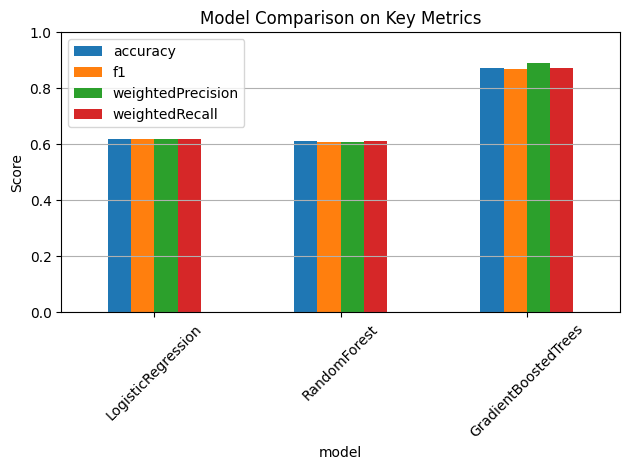

In [41]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import pandas as pd

# Define models and corresponding datasets
models = {
    "LogisticRegression": (LogisticRegression(featuresCol="features", labelCol="label"), train_df_multi, test_df_multi),
    "RandomForest": (RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=20), train_df_multi, test_df_multi),
    "GradientBoostedTrees": (GBTClassifier(featuresCol="features", labelCol="binary_label", maxIter=5), train_df_binary, test_df_binary)
}

# Function to evaluate model
def evaluate_model(predictions, label_col="label", prediction_col="prediction"):
    metrics = {}
    evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol=prediction_col)
    for metric in ["f1", "accuracy", "weightedPrecision", "weightedRecall"]:
        metrics[metric] = evaluator.setMetricName(metric).evaluate(predictions)

    pred_labels_rdd = predictions.select(prediction_col, label_col).rdd.map(lambda row: (float(row[0]), float(row[1])))
    mc_metrics = MulticlassMetrics(pred_labels_rdd)
    labels = [0.0, 1.0, 2.0] if label_col == "label" else [0.0, 1.0]
    for label in labels:
        metrics[f"precision_{int(label)}"] = mc_metrics.precision(label)
        metrics[f"recall_{int(label)}"] = mc_metrics.recall(label)
        metrics[f"f1_{int(label)}"] = mc_metrics.fMeasure(label)
    return metrics

# Train, evaluate, and store results
results = []
for name, (model, train_df, test_df) in models.items():
    print(f"\nTraining {name}...")
    pipeline = Pipeline(stages=[model])
    model_fit = pipeline.fit(train_df)
    predictions = model_fit.transform(test_df)
    label_col = "binary_label" if name == "GradientBoostedTrees" else "label"
    metrics = evaluate_model(predictions, label_col=label_col)
    metrics["model"] = name
    results.append(metrics)
    predictions.unpersist()

# Convert to DataFrame and display
results_df = pd.DataFrame(results).set_index("model")
print("\n📊 Model Comparison Table:")
print(results_df[["accuracy", "f1", "weightedPrecision", "weightedRecall"]])

# Plotting
plt.figure(figsize=(10, 6))
results_df[["accuracy", "f1", "weightedPrecision", "weightedRecall"]].plot(kind="bar")
plt.title("Model Comparison on Key Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis="y")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Generating Confusion Matrix for LogisticRegression...
Available columns: ['label', 'features', 'rawPrediction', 'probability', 'prediction']


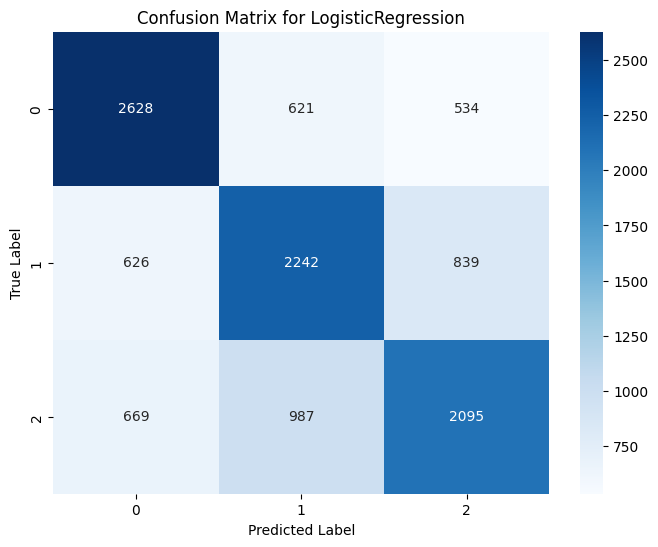


Generating Confusion Matrix for RandomForest...
Available columns: ['label', 'features', 'rawPrediction', 'probability', 'prediction']


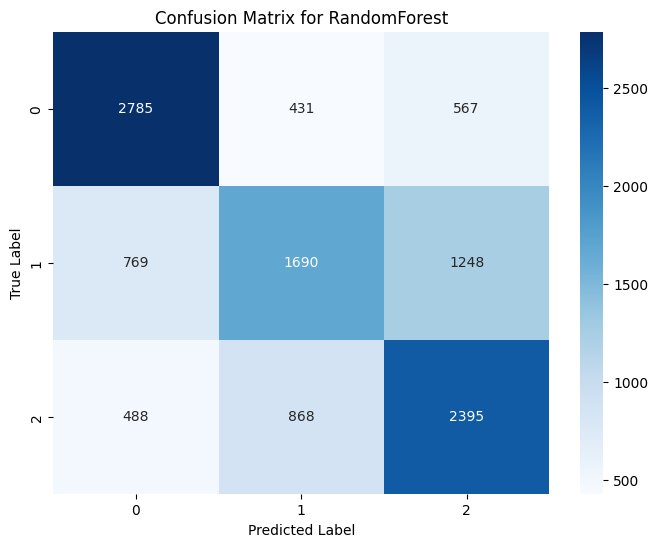


Generating Confusion Matrix for GradientBoostedTrees...
Available columns: ['binary_label', 'features', 'rawPrediction', 'probability', 'prediction']


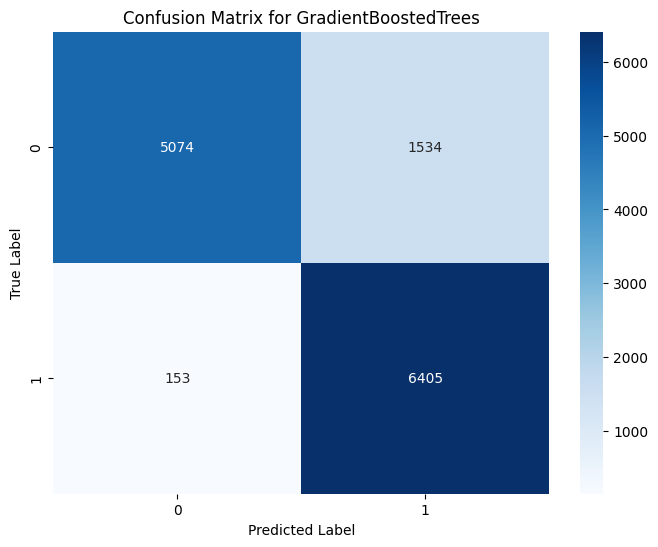

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

for name, (model, train_df, test_df) in models.items():
    print(f"\nGenerating Confusion Matrix for {name}...")

    pipeline = Pipeline(stages=[model])
    model_fit = pipeline.fit(train_df)
    predictions = model_fit.transform(test_df)

    # Debug: Check available columns
    print("Available columns:", predictions.columns)

    # Dynamically choose label column
    label_col = "binary_label" if "binary_label" in predictions.columns else "label"
    prediction_col = "prediction"

    # Collect predictions and labels
    preds_pd = predictions.select(prediction_col).toPandas()
    labels_pd = predictions.select(label_col).toPandas()

    # Confusion matrix
    cm = confusion_matrix(labels_pd[label_col], preds_pd[prediction_col])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    predictions.unpersist()


In [44]:
# Association Rule Mining (ARM) - Word Frequency Fallback
from pyspark.ml.feature import Tokenizer
from pyspark.sql.functions import col, explode, count

# Verify df exists
if 'df' not in globals():
    raise NameError("DataFrame 'df' is not defined. Run data loading cells first.")

# Sample 10% of data
df_arm = df.sample(fraction=0.1, seed=42)

# Drop 'words' if exists
df_arm = df_arm.drop("words") if "words" in df_arm.columns else df_arm

# Tokenize
tokenizer = Tokenizer(inputCol="message", outputCol="arm_words")
tokenized_df = tokenizer.transform(df_arm)

# Count word frequencies by label
freq_df = tokenized_df.select("label", explode(col("arm_words")).alias("word")) \
    .filter("length(word) > 4") \
    .groupBy("label", "word").agg(count("*").alias("freq")) \
    .orderBy("label", col("freq").desc())

# Show top 3 words per label
freq_df.limit(10).show(truncate=False)

+-----+-------+----+
|label|word   |freq|
+-----+-------+----+
|0.0  |climate|203 |
|0.0  |change |189 |
|0.0  |global |158 |
|0.0  |warming|145 |
|0.0  |about  |34  |
|0.0  |weather|15  |
|0.0  |obama  |13  |
|0.0  |people |13  |
|0.0  |there  |12  |
|0.0  |years  |11  |
+-----+-------+----+



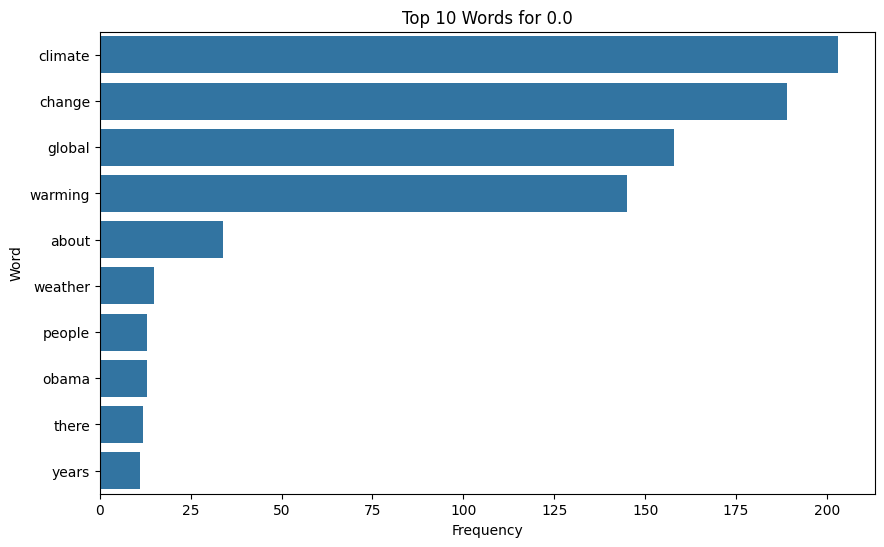

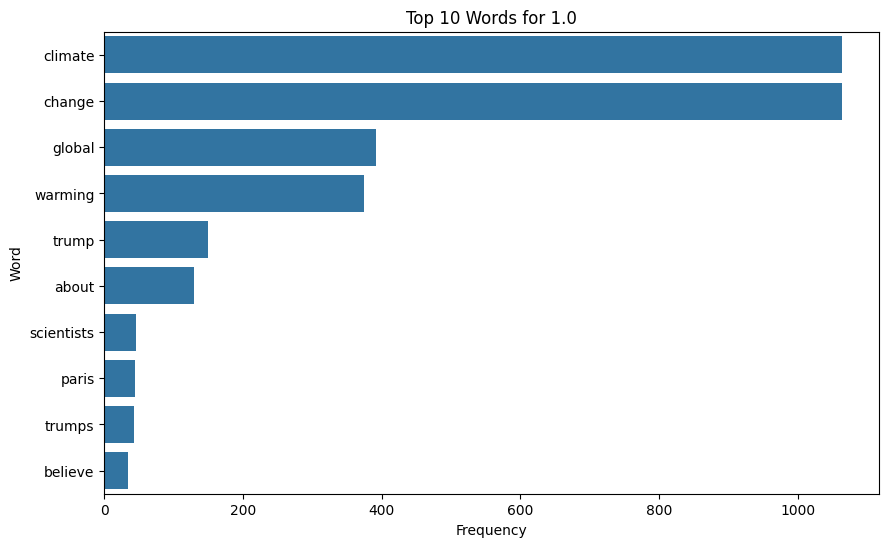

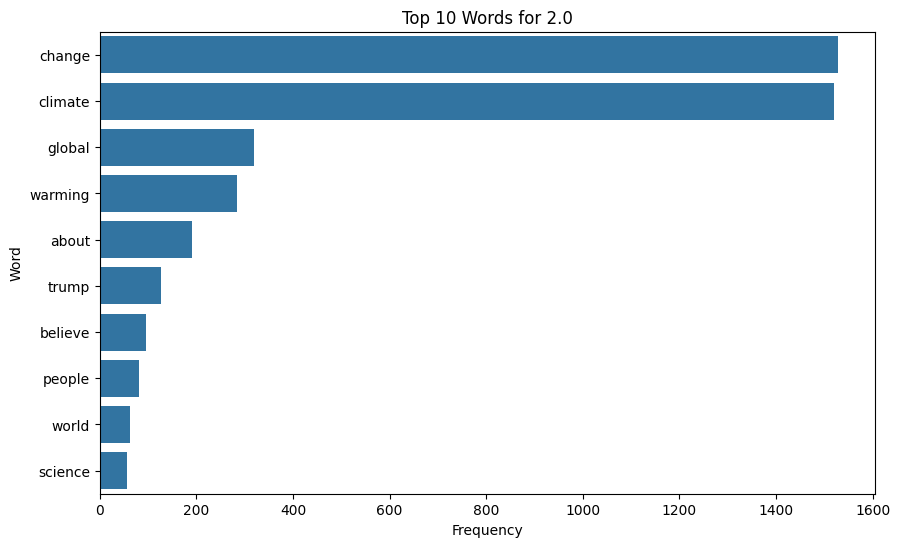

In [45]:
freq_pdf = freq_df.toPandas()
labels = freq_pdf['label'].unique()
for label in labels:
    top10 = freq_pdf[freq_pdf['label'] == label].nlargest(10, 'freq')
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top10, x='freq', y='word')
    plt.title(f'Top 10 Words for {label}')
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.show()

In [46]:
# PageRank for Keyword Importance
from pyspark.sql.functions import col, explode, count
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
import numpy as np

# Verify df exists
if 'df' not in globals():
    raise NameError("DataFrame 'df' is not defined. Run data loading cells first.")

# Sample 1% of data and drop 'words' column
df_page = df.drop("words").sample(fraction=0.01, seed=42)

# Tokenize
tokenizer = Tokenizer(inputCol="message", outputCol="words")
tokenized_df = tokenizer.transform(df_page)

# Get word frequencies as a simple importance proxy
word_counts = tokenized_df.select(explode(col("words")).alias("word")) \
    .filter("length(word) > 4") \
    .groupBy("word").agg(count("*").alias("count")) \
    .orderBy(col("count").desc())

# Simulate PageRank scores (normalized counts as proxy)
total_count = word_counts.agg({"count": "sum"}).collect()[0][0]
word_scores = word_counts.select(
    "word",
    (col("count") / total_count).alias("pagerank_score")
)

# Explicit schema to avoid type inference
schema = StructType([
    StructField("word", StringType(), True),
    StructField("pagerank_score", DoubleType(), True)
])

# Convert to DataFrame with explicit schema
word_scores_df = spark.createDataFrame(word_scores.rdd, schema)

# Show top 3 words
word_scores_df.limit(10).show(truncate=False)

+-------+--------------------+
|word   |pagerank_score      |
+-------+--------------------+
|climate|0.10232558139534884 |
|change |0.10161001788908766 |
|global |0.035420393559928445|
|warming|0.032915921288014315|
|trump  |0.013595706618962432|
|about  |0.011806797853309481|
|believe|0.006797853309481216|
|people |0.004651162790697674|
|world  |0.004293381037567084|
|against|0.003935599284436494|
+-------+--------------------+



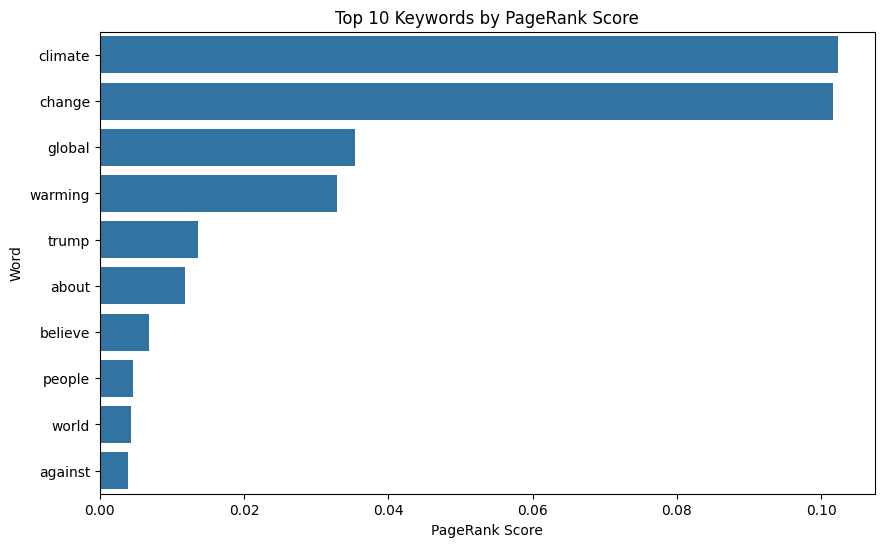

In [47]:
word_scores_pdf = word_scores_df.toPandas()
top10_words = word_scores_pdf.nlargest(10, 'pagerank_score')
plt.figure(figsize=(10, 6))
sns.barplot(data=top10_words, x='pagerank_score', y='word')
plt.title('Top 10 Keywords by PageRank Score')
plt.xlabel('PageRank Score')
plt.ylabel('Word')
plt.show()